## Imports

In [1]:
from __future__ import division, print_function, absolute_import
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from math import ceil
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import pickle 
import scipy.ndimage
from PIL import Image as PILImage

## Mount drive if necessary

In [5]:
# from google.colab import drive
# drive.mount('gdrive/')
# os.chdir('gdrive/My Drive/Colab Notebooks/FACT/')
# '/gdrive/My Drive/Colab Notebooks/NLP1/Practical 2/googlenews.word2vec.300d.txt'

## Helper functions
Helper functions borrowed from original paper by Li et al. 

In [2]:
def makedirs(path):
    '''
    if path does not exist in the file system, create it
    '''
    if not os.path.exists(path):
        os.makedirs(path)

def list_of_norms(X):
    '''
    X is a list of vectors X = [x_1, ..., x_n], we return
        [d(x_1, x_1), d(x_2, x_2), ... , d(x_n, x_n)], where the distance
    function is the squared euclidean distance.
    '''
    return torch.sum(torch.pow(X, 2), dim=1)

def print_and_write(str, file):
    '''
    print str to the console and also write it to file
    '''
    print(str)
    file.write(str + '\n')

In [3]:
os.getcwd()

'/Users/TomLotze/Documents/Artificial Intelligence/Year1/FACT/FACT/Reproduction'

## Create necessary folders

In [4]:
# data folder
makedirs('./data/mnist_color28')

# Models folder
model_folder = os.path.join(os.getcwd(), "saved_model", "mnist_model_color28")
makedirs(model_folder)

# Image folder
img_folder = os.path.join(model_folder, "img")
makedirs(img_folder)

# Model filename
model_filename = "mnist_cae_color28"

In [5]:
# # Transforms to perform on loaded dataset. Normalize around mean 0.1307 and std 0.3081 for optimal pytorch results. 
# # source: https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/4
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,),(0.3081,))])

# Load datasets into reproduction/data/mnist. Download if data not present. 
mnist_train = DataLoader(torchvision.datasets.MNIST('./data/mnist', train=True, download=True, transform=transforms))

mnist_train_data = mnist_train.dataset.data
mnist_train_targets = mnist_train.dataset.targets

# first 55000 examples for training
x_train = mnist_train_data[0:55000]
y_train = mnist_train_targets[0:55000]

# 5000 examples for validation set
x_valid = mnist_train_data[55000:60000]
y_valid = mnist_train_targets[55000:60000]

# 10000 examples in test set
mnist_test = DataLoader(torchvision.datasets.MNIST('./data/mnist', train=False, download=True, 
                                                   transform=transforms))

x_test = mnist_test.dataset.data
y_test = mnist_test.dataset.targets

train_data = TensorDataset(x_train, y_train)
valid_data = TensorDataset(x_valid, y_valid)
test_data = TensorDataset(x_test, y_test)


100.1%

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz


28.4%

0.5%5%

Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz


100.4%

Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz


180.4%

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [6]:
def color_dataset(raw_data):
    N = len(raw_data)
    raw_data = raw_data.view(N, 28, 28, 1)
    
    # Extend to RGB
    data_rgb = np.concatenate([raw_data, raw_data, raw_data], axis=3)
    
    # Make binary
    data_binary = (data_rgb > 0.5)
    data_color = np.zeros((N, 28, 28, 3))
    
    for i in range(N):
        # Take a random crop of the Lena image (background)
        x_c = np.random.randint(0, lena.size[0] - 28)
        y_c = np.random.randint(0, lena.size[1] - 28)
        image = lena.crop((x_c, y_c, x_c + 28, y_c + 28))
        image = np.asarray(image) / 255.0
        
        # Change color distribution
        for j in range(3):
            image[:, :, j] = (image[:, :, j] + np.random.uniform(0, 1)) / 2.0

        # Invert the colors at the location of the number
        image[data_binary[i]] = 1 - image[data_binary[i]]
        data_color[i] = image

    return torch.from_numpy(data_color)


## Add background to dataset

In [7]:
lena = PILImage.open('./resources/lena.png')

x_train_color = color_dataset(mnist_train_data)
x_test_color = color_dataset(x_test)

print(x_train_color.shape)
print(x_test_color.shape)

torch.Size([60000, 28, 28, 3])
torch.Size([10000, 28, 28, 3])


In [8]:
train_data_color = TensorDataset(x_train_color, mnist_train_targets)
test_data_color = TensorDataset(x_test_color, y_test)

## Save dataset

In [9]:
with open("./data/mnist_color28/MNIST_color28_train.p", "wb") as f:
    pickle.dump(train_data_color, f)
    
with open("./data/mnist_color28/MNIST_color28_test.p", "wb") as f:
    pickle.dump(test_data_color, f)

## Load the dataset

In [10]:
with open("./data/mnist_color28/MNIST_color28_train.p", "rb") as f:
    mnist_train = pickle.load(f)

with open("./data/mnist_color28/MNIST_color28_test.p", "rb") as f:
    mnist_test = pickle.load(f)
    
# first 55000 examples for training
x_train = mnist_train[0:55000][0]
y_train = mnist_train[0:55000][1]
# y_train = mnist_train_targets[0:55000]

# 5000 examples for validation set
x_valid = mnist_train[55000:60000][0]
y_valid = mnist_train[55000:60000][1]

# 10000 examples in test set
x_test = mnist_test[:][0]
y_test = mnist_test[:][1]

train_data = TensorDataset(x_train, y_train)
valid_data = TensorDataset(x_valid, y_valid)
test_data = TensorDataset(x_test, y_test)

## Parameters

In [11]:
# COPIED FROM THE ORIGINAL IMPLEMENTATION
# training parameters
learning_rate = 0.002
training_epochs = 1500

# frequency of testing and saving
test_display_step = 5    # how many epochs we do evaluate on the test set once, default 100
save_step = 50            # how frequently do we save the model to disk

# elastic deformation parameters
sigma = 4
alpha = 20

# lambda's are the ratios between the four error terms
lambda_class = 20
lambda_ae = 1 # autoencoder
lambda_1 = 1 # push prototype vectors to have meaningful decodings in pixel space
lambda_2 = 1 # cluster training examples around prototypes in latent space


input_height = input_width =  28    # MNIST data input shape 
n_input_channel = 3     # the number of color channels; for MNIST is 1.
input_size = input_height * input_width * n_input_channel   # 784
n_classes = 10

# Network Parameters
n_prototypes = 15         # the number of prototypes
n_layers = 4

# height and width of each layers' filters
f_1 = 3
f_2 = 3
f_3 = 3
f_4 = 3

# stride size in each direction for each of the layers
s_1 = 2
s_2 = 2
s_3 = 2
s_4 = 2

# number of feature maps in each layer
n_map_1 = 32
n_map_2 = 32
n_map_3 = 32
n_map_4 = 10

# the shapes of each layer's filter
# [out channel, in_channel, 3, 3]
filter_shape_1 = [n_map_1, n_input_channel, f_1, f_1]
filter_shape_2 = [n_map_2, n_map_1, f_2, f_2]
filter_shape_3 = [n_map_3, n_map_2, f_3, f_3]
filter_shape_4 = [n_map_4, n_map_3, f_4, f_4]

# strides for each layer (changed to tuples)
stride_1 = [s_1, s_1]
stride_2 = [s_2, s_2]
stride_3 = [s_3, s_3]
stride_4 = [s_4, s_4]


## Model construction
#### <font color='red'>Fix the stride and padding parameters, check if filter in tf is same as weight in pt</font>
Padding discussion pytorch: https://github.com/pytorch/pytorch/issues/3867

Blogpost: https://mmuratarat.github.io/2019-01-17/implementing-padding-schemes-of-tensorflow-in-python

In [49]:
class Encoder(nn.Module):
    '''Encoder'''
    def __init__(self):
        super(Encoder, self).__init__()
        
        # height and width of each layers' filters
        f_1 = 3
        f_2 = 3
        f_3 = 3
        f_4 = 3
        
        # define layers
        self.enc_l1 = nn.Conv2d(n_input_channel, 32, kernel_size=3, stride=2, padding=0)
        self.enc_l2 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=0)
        self.enc_l3 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=0)
        self.enc_l4 = nn.Conv2d(32, 10, kernel_size=3, stride=2, padding=0)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        
    def pad_image(self, img):
        ''' Takes an input image (batch) and pads according to Tensorflows SAME padding'''
        input_h = img.shape[2]
        input_w = img.shape[3]
        stride = 2 
        filter_h = 3
        filter_w = 3

        output_h = int(ceil(float(input_h)) / float(stride))
        output_w = output_h

        if input_h % stride == 0:
            pad_height = max((filter_h - stride), 0)
        else:
            pad_height = max((filter_h - (input_h % stride), 0))

        pad_width = pad_height

        pad_top = pad_height // 2
        pad_bottom = pad_height - pad_top
        pad_left = pad_width // 2
        pad_right = pad_width - pad_left

        padded_img = torch.zeros(img.shape[0], img.shape[1], input_h + pad_height, input_w + pad_width)
        padded_img[:,:, pad_top:-pad_bottom, pad_left:-pad_right] = img

        return padded_img
        
    def forward(self, x):
        pad_x = self.pad_image(x)
        el1 = self.relu(self.enc_l1(pad_x))
        
        pad_el1 = self.pad_image(el1)
        el2 = self.relu(self.enc_l2(pad_el1))
    
        pad_el2 = self.pad_image(el2)
        el3 = self.relu(self.enc_l3(pad_el2))
        
        pad_el3 = self.pad_image(el3)
        el4 = self.relu(self.enc_l4(pad_el3))
        
        return el4
        

class nn_prototype(nn.Module):
    '''Model'''
    def __init__(self, n_prototypes=15, n_layers=4, n_classes=10):
        super().__init__()
        
        self.encoder = Encoder()
        
        # initialize prototype - currently not in correct spot
        
        # changed this for the colored mnist, from 40 to 160, the new shape would be 250*10*4*4
        n_features = 40 # size of encoded x - 250 x 10 x 2 x 2
        self.prototype_replacement = nn.Linear(n_features, n_prototypes)
        
                                                        
        
        self.last_layer = nn.Linear(n_prototypes,10)

    
    def forward(self, x):
    
        #encoder step
        enc_x = self.encoder(x)
        
        x = enc_x.view(enc_x.shape[0], -1)
    
    
        x = self.prototype_replacement(x)
        
        # classification layer
        logits = self.last_layer(x)
        
        # Softmax to prob dist not needed as cross entropy loss is used?
        
        return logits
        

## Cost function

In [50]:
'''
the error function consists of 4 terms, the autoencoder loss,
the classification loss, and the two requirements that every feature vector in
X look like at least one of the prototype feature vectors and every prototype
feature vector look like at least one of the feature vectors in X.
'''
def loss_function(logits, Y):
    return F.cross_entropy(logits, Y, reduction="mean")

## Accuracy

In [51]:
def compute_acc(logits, labels):
    batch_size = labels.shape[0]
    predictions = logits.argmax(dim=1)
    total_correct = torch.sum(predictions == labels).item()
    accuracy = total_correct / batch_size
    
    return(accuracy)

## Training loop

In [52]:
model = nn_prototype(15,4,10)
batch_size_ = 250

# get validation and test set
valid_dl = DataLoader(valid_data, batch_size=5000, drop_last=False, shuffle=False)
test_dl = DataLoader(test_data, batch_size=10000, drop_last=False, shuffle=False)


# initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# initialize storage for results
train_accs = []
train_losses = []
test_accs = []
test_losses = []
valid_accs = []
valid_losses = []

# training loop
for epoch in range(training_epochs):
    print("\nEpoch:", epoch)

    # load the training data and reshuffle
    train_dl = DataLoader(train_data, batch_size=batch_size_, drop_last=False, shuffle=True)

    # loop over the batches
    for step, (x, Y) in enumerate(train_dl):
        optimizer.zero_grad()
        
        x_plot = x[0].clone()
        
        x = x.view(x.shape[0], n_input_channel, x.shape[1], x.shape[2]).float()

        #Y = Y.long()
        
        # perform forward pass
        logits = model(x)

        # compute the loss
        total_loss = loss_function(logits, Y)

        # backpropagate over the loss
        total_loss.backward()

        # update the weights
        optimizer.step()

        # compute and save accuracy and loss
        train_accuracy = compute_acc(logits, Y)
        train_accs.append(train_accuracy)
        train_losses.append(total_loss.item())


    # print information after a batch
    print('Last train loss of batch:', total_loss.item())
    print('Train acc on batch:', np.mean(train_accs[-step:]))
    print("Last train acc", train_accuracy)


    if epoch % test_display_step == 0:
        # save model and prototypes
        #torch.save(model, model_folder + "/" + model_filename + "_epoch_" + str(epoch) + '.pt')

        
        # perform testing
        with torch.no_grad():
            for (x_test, y_test) in test_dl:
                x_test = x_test.view(x_test.shape[0], n_input_channel, x_test.shape[1], x_test.shape[2]).float()

                # forward pass
                logits = model(x_test)

                # compute loss and accuracy and save
                test_accuracy = compute_acc(logits, y_test)
                test_loss = loss_function(logits, y_test)
                test_accs.append(test_accuracy)
                test_losses.append(test_loss)

            print('\nTest loss:', test_loss.item())
            print('Test acc:', test_accuracy)

    # validation
    with torch.no_grad():
        for (x_valid, y_valid) in valid_dl:
                x_valid = x_valid.view(x_valid.shape[0], n_input_channel, x_valid.shape[1], x_valid.shape[2]).float()
        
                logits = model(x_valid)

                # compute losses and accuracy and save
                valid_accuracy = compute_acc(logits, y_valid)
                valid_loss = loss_function(logits, y_valid)
                valid_accs.append(valid_accuracy)
                valid_losses.append(valid_loss)

        print('\nValid loss:', valid_loss.item())
        print('Valid acc:', valid_accuracy)
    



Epoch: 0
Last train loss of batch: 0.909442663192749
Train acc on batch: 0.40268493150684925
Last train acc 0.688

Test loss: 0.926217257976532
Test acc: 0.7104

Valid loss: 0.8852108120918274
Valid acc: 0.7224

Epoch: 1
Last train loss of batch: 0.6103574633598328
Train acc on batch: 0.769041095890411
Last train acc 0.808

Valid loss: 0.5575230717658997
Valid acc: 0.8322

Epoch: 2
Last train loss of batch: 0.4940646290779114
Train acc on batch: 0.8281643835616438
Last train acc 0.856

Valid loss: 0.45513004064559937
Valid acc: 0.8642

Epoch: 3
Last train loss of batch: 0.3459125757217407
Train acc on batch: 0.8517625570776257
Last train acc 0.876

Valid loss: 0.4136239290237427
Valid acc: 0.8742

Epoch: 4
Last train loss of batch: 0.48878318071365356
Train acc on batch: 0.8658630136986303
Last train acc 0.86

Valid loss: 0.3735973536968231
Valid acc: 0.8914

Epoch: 5
Last train loss of batch: 0.311738520860672
Train acc on batch: 0.8787762557077625
Last train acc 0.904

Test loss: 0.


Valid loss: 0.4192601144313812
Valid acc: 0.9156

Epoch: 47
Last train loss of batch: 0.08404260128736496
Train acc on batch: 0.9643287671232876
Last train acc 0.96

Valid loss: 0.4258142113685608
Valid acc: 0.909

Epoch: 48
Last train loss of batch: 0.08662189543247223
Train acc on batch: 0.9668127853881278
Last train acc 0.96

Valid loss: 0.4338178336620331
Valid acc: 0.9108

Epoch: 49
Last train loss of batch: 0.1151108592748642
Train acc on batch: 0.967890410958904
Last train acc 0.972

Valid loss: 0.45127350091934204
Valid acc: 0.9152

Epoch: 50
Last train loss of batch: 0.1653820276260376
Train acc on batch: 0.9663926940639269
Last train acc 0.948

Test loss: 0.5149051547050476
Test acc: 0.9018

Valid loss: 0.4346694350242615
Valid acc: 0.9154

Epoch: 51
Last train loss of batch: 0.059137407690286636
Train acc on batch: 0.9667945205479452
Last train acc 0.976

Valid loss: 0.453766793012619
Valid acc: 0.9148

Epoch: 52
Last train loss of batch: 0.15922610461711884
Train acc on ba

KeyboardInterrupt: 

## Loading the model and visualize prototypes

In [ ]:
# # load the model
# loaded_model = torch.load(model_folder+"/"+model_filename)

# with torch.no_grad():
#         for step, (x_valid, y_valid) in enumerate(valid_dl):
#                 x_valid = x_valid.view(x_valid.shape[0], 1, x_valid.shape[1], x_valid.shape[2]).float()
#                 X_decoded, logits, feature_dist, prot_dist = loaded_model(x_valid)

#                 # Check is model is indeed trained
#                 valid_accuracy = compute_acc(logits, y_valid)
#                 valid_loss = loss_function(X_decoded, x_valid, logits, y_valid, feature_dist, prot_dist)

#         print('\nValid loss:', valid_loss.item())
#         print('Valid acc:', valid_accuracy)

# visualize_prototypes(loaded_model, 1, False)

In [ ]:
# visualize prototypes from current model (in memory, not the loaded one)
visualize_prototypes(model, 1, 0)

## Saving and plotting of losses and accuracies

---



In [0]:
with open(model_folder + '/train_accs.p', 'wb') as f:
    pickle.dump(train_accs, f)

with open(model_folder + '/test_accs.p', 'wb') as f:
    pickle.dump(test_accs, f)

with open(model_folder + '/valid_accs.p', 'wb') as f:
    pickle.dump(valid_accs, f)

with open(model_folder + '/train_losses.p', 'wb') as f:
    pickle.dump(train_losses, f)

with open(model_folder + '/test_losses.p', 'wb') as f:
    pickle.dump(test_losses, f)

with open(model_folder + '/valid_losses.p', 'wb') as f:
    pickle.dump(valid_losses, f)

19020
86
18


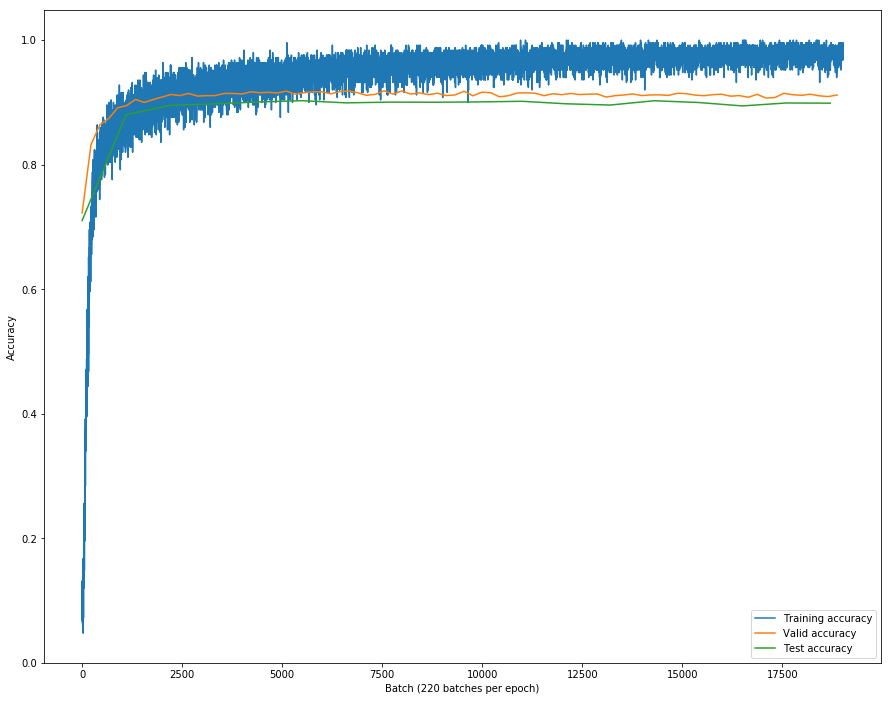

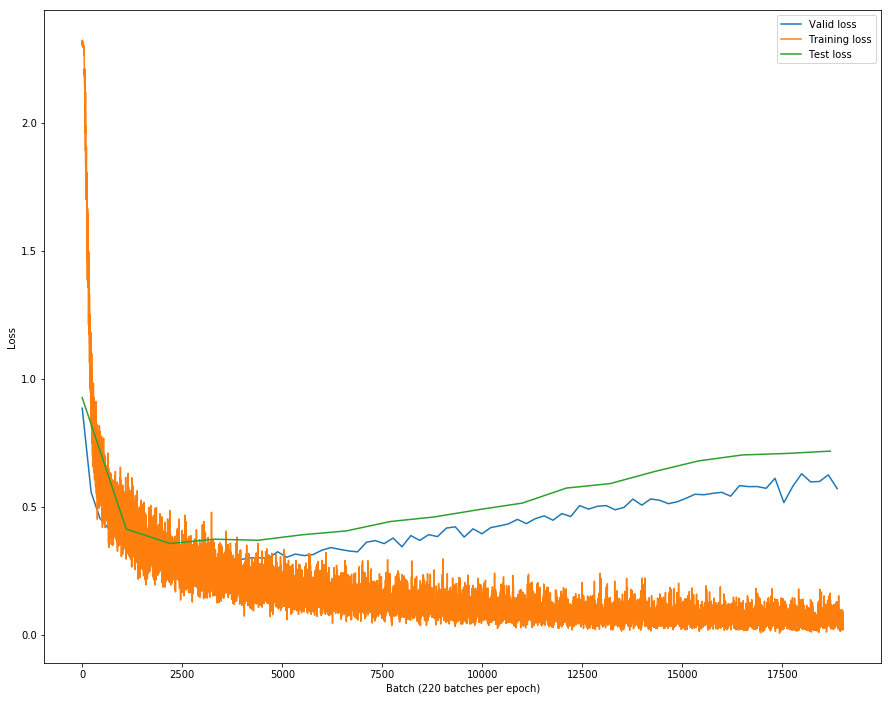

In [83]:
train_epochs = list(range(0,len(train_accs)))
valid_epochs = list(range(0,len(train_accs),222))
test_epochs = list(range(0,len(train_accs),test_display_step*220))
print(len(train_accs))
print(len(valid_accs))
print(len(test_accs))
plt.figure(figsize=(15,12))
plt.plot(train_epochs, train_accs, label="Training accuracy")
plt.plot(valid_epochs, valid_accs, label="Valid accuracy")
plt.plot(test_epochs, test_accs, label="Test accuracy")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Batch (220 batches per epoch)")
plt.show()

plt.figure(figsize=(15,12))
plt.plot(valid_epochs, valid_losses, label="Valid loss")
plt.plot(train_epochs, train_losses, label="Training loss")
plt.plot(test_epochs, test_losses, label="Test loss")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Batch (220 batches per epoch)")
plt.show()